adapted from:
https://docs.ray.io/en/latest/train/examples/train_fashion_mnist_example.html

In [1]:
%xmode Minimal

Exception reporting mode: Minimal


In [2]:
import os
import glob
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.modules.utils import consume_prefix_in_state_dict_if_present
import torch.nn.functional as F
import torchvision
from torchvision.transforms import ToTensor, Resize,Compose, ToPILImage

from sklearn.metrics import classification_report, confusion_matrix

import ray
from ray import train
from ray import tune
import ray.train.torch
from ray.train import Trainer
from ray.train import CheckpointStrategy
from ray.data.datasource import SimpleTorchDatasource

import matplotlib.pyplot as plt

from ray_cluster_control import start_ray_cluster, stop_ray_cluster

/opt/app-root/lib64/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
transforms = Compose([Resize((64, 64)), ToTensor()])

pet_data = torchvision.datasets.OxfordIIITPet(
    "data/",download = True,
    target_types = "category",
    transform = transforms,
    split = "trainval")

data_loader = torch.utils.data.DataLoader(pet_data, batch_size=4, shuffle=True)

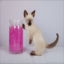

label:32


In [4]:
train_features, train_labels = next(iter(data_loader))
as_image = ToPILImage()
as_image(train_features[0]).show()
print(f'label:{train_labels[0]}')

In [8]:
ray_cluster_name = os.getenv('RAY_CLUSTER_NAME')
start_ray_cluster(cluster_name = ray_cluster_name)

RayCluster octo-next-eje has started


In [9]:
ray.init(f'ray://{ray_cluster_name}-ray-head:10001')

ClientContext(dashboard_url='10.128.4.244:8265', python_version='3.8.12', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', protocol_version='2022-03-16', _num_clients=1, _context_to_restore=<ray.util.client._ClientContext object at 0x7efeba6161c0>)

In [10]:
#stop_ray_cluster(cluster_name = ray_cluster_name)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
device = "cpu"

cpu


In [12]:
# modified from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3,1 )
        
        self.fc1 = nn.Linear(6272 , 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 37)
        
        self.dropout1 = nn.Dropout(0.25)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool((self.conv1(x)))
        x = self.pool((self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        y_pred = self.fc3(x)
        return y_pred

### stage data using Ray Data

In [13]:
dataset_factory = lambda: torchvision.datasets.OxfordIIITPet(
    "data/",
    download = True,
    target_types = "category",
    transform = transforms,
    split = "trainval")

In [14]:
dataset = ray.data.read_datasource(
    SimpleTorchDatasource(),
    parallelism=1,
    dataset_factory=dataset_factory
)

Caught schedule exception


(_execute_read_task pid=316) Downloading https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz to data/oxford-iiit-pet/images.tar.gz


100%|██████████| 791918971/791918971 [00:40<00:00, 19511324.32it/s]


(_execute_read_task pid=316) Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet
(_execute_read_task pid=316) Downloading https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz to data/oxford-iiit-pet/annotations.tar.gz


 83%|████████▎ | 15958016/19173078 [00:01<00:00, 17276360.68it/s]


(_execute_read_task pid=316) Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 14135715.46it/s]


In [15]:
x = dataset.random_shuffle().repartition(2).split(2)
x

Shuffle Map:   0%|          | 0/1 [00:02<?, ?it/s]

(map pid=203, ip=10.131.2.49) Downloading https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz to data/oxford-iiit-pet/images.tar.gz


Shuffle Map:   0%|          | 0/1 [01:01<?, ?it/s]

(map pid=203, ip=10.131.2.49) Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


Shuffle Map:   0%|          | 0/1 [01:06<?, ?it/s]

(map pid=203, ip=10.131.2.49) Downloading https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz to data/oxford-iiit-pet/annotations.tar.gz


Shuffle Map:   0%|          | 0/1 [01:09<?, ?it/s]

(map pid=203, ip=10.131.2.49) Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


Repartition: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


[Dataset(num_blocks=1, num_rows=1840, schema=<class 'tuple'>),
 Dataset(num_blocks=1, num_rows=1840, schema=<class 'tuple'>)]

In [16]:
train_data = x[0]
test_data = x[1]

In [17]:
def train_epoch(dataloader, model, loss_fn, optim):
    model.train()
    model.to("cuda")
    for batch_idx, data in enumerate(dataloader.iter_batches()):
        X = [x[0] for x in data]
        X = torch.stack(X)
        X = X.to("cuda")
        y = [torch.tensor(x[1]) for x in data]
        y = torch.stack(y)
        y = y.to("cuda")
        pred = model(X)
        loss = loss_fn(pred, y)
        
        #backprop
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    return loss.item()

In [18]:
def validate_epoch(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for data in dataloader.iter_batches():
            X = [x[0] for x in data]
            X = torch.stack(X)
            X = X.to("cuda")
            y = [torch.tensor(x[1]) for x in data]
            y = torch.stack(y)
            y = y.to("cuda")
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    
    return test_loss/dataloader.num_blocks()

In [19]:
def train_func(config):
    batch_size = config["batch_size"]
    lr = config["lr"]
    epochs = config["epochs"]
    momentum = config["momentum"]
    tune_run = config["tune_run"]
    
    train_dataloader = train_data
    test_dataloader = test_data
    model = ConvNet()
    #model = train.torch.prepare_model(model)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr,  momentum=momentum)
    
    loss_results = []
    eval_results = []
    
    for epoch in range(epochs):
        loss = train_epoch(train_dataloader, model, loss_fn, optimizer)
        val_loss = validate_epoch(test_dataloader, model, loss_fn)
        #train.report(loss=val_loss)
        loss_results.append(loss)
        eval_results.append(val_loss)
        if not tune_run:
            if epoch % 100 == 0:
                print(f"epoch:{epoch}  loss {loss:>7f}")
                print(f"eval loss: {val_loss:>7f}")    

            if epoch == epochs-1:
                state_dict = model.state_dict()
                consume_prefix_in_state_dict_if_present(state_dict, "module.")
                train.save_checkpoint(epoch=epochs, model_weights=state_dict)
    
    if tune_run:
        tune.report(loss=loss)
    
    return loss_results, eval_results

### Tune! 

In [20]:
# Define a search space.
search_space = {
    "lr": tune.grid_search([0.1]),
    "momentum": tune.grid_search([0.1, 0.9]),
    "batch_size": tune.grid_search([4]),
    "epochs": tune.grid_search([200, 100]),
    "tune_run": tune.grid_search([True])
}

In [21]:
%%time
analysis = tune.run(
    tune.with_parameters(train_func),
    config=search_space,
    resources_per_trial={'gpu': 1})

(run pid=316) 2022-09-12 22:22:34,103	WARNING function_runner.py:603 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
(run pid=316) 2022-09-12 22:22:34,950	ERROR syncer.py:147 -- Log sync requires rsync to be installed.


(run pid=316) == Status ==
(run pid=316) Current time: 2022-09-12 22:22:37 (running for 00:00:03.43)
(run pid=316) Memory usage on this node: 8.4/30.9 GiB
(run pid=316) Using FIFO scheduling algorithm.
(run pid=316) Resources requested: 1.0/2 CPUs, 1.0/2 GPUs, 0.0/8.4 GiB heap, 0.0/3.51 GiB objects
(run pid=316) Result logdir: /home/ray_results/train_func_2022-09-12_22-22-34
(run pid=316) Number of trials: 4/4 (3 PENDING, 1 RUNNING)
(run pid=316) +------------------------+----------+-------------------+--------------+----------+------+------------+------------+
(run pid=316) | Trial name             | status   | loc               |   batch_size |   epochs |   lr |   momentum | tune_run   |
(run pid=316) |------------------------+----------+-------------------+--------------+----------+------+------------+------------|
(run pid=316) | train_func_66295_00000 | RUNNING  | 10.128.4.244:2057 |            4 |      200 |  0.1 |        0.1 | True       |
(run pid=316) | train_func_66295_00001 

(run pid=316) 2022-09-12 22:25:28,094	INFO tune.py:747 -- Total run time: 174.09 seconds (173.85 seconds for the tuning loop).


In [22]:
print(analysis.get_best_config(metric="loss", mode="min"))

{'lr': 0.1, 'momentum': 0.1, 'batch_size': 4, 'epochs': 200, 'tune_run': True}


### Now that we know best param, we'll train and save our model. This prevents us from saving N model trails that we'll need to deleted later.  

In [23]:
%%time
trainer = Trainer(backend="torch", num_workers=2, use_gpu=True)
trainer.start()

2022-09-12 22:25:56,423	INFO trainer.py:243 -- Trainer logs will be logged in: /opt/app-root/src/ray_results/train_2022-09-12_22-25-56
(BaseWorkerMixin pid=442, ip=10.131.2.49) 2022-09-12 22:26:00,993	INFO torch.py:346 -- Setting up process group for: env:// [rank=0, world_size=2]
(BaseWorkerMixin pid=293, ip=10.128.2.60) 2022-09-12 22:26:01,084	INFO torch.py:346 -- Setting up process group for: env:// [rank=1, world_size=2]


CPU times: user 23.5 ms, sys: 4.42 ms, total: 28 ms
Wall time: 4.89 s


In [24]:
%%time
config = analysis.get_best_config(metric="loss", mode="min")
config["tune_run"] = False

loss, eval_ = trainer.run(train_func = train_func,
                          config = config)

2022-09-12 22:26:22,013	INFO trainer.py:249 -- Run results will be logged in: /opt/app-root/src/ray_results/train_2022-09-12_22-25-56/run_001


(BaseWorkerMixin pid=442, ip=10.131.2.49) epoch:0  loss 3.615201
(BaseWorkerMixin pid=442, ip=10.131.2.49) eval loss: 3.613781
(BaseWorkerMixin pid=293, ip=10.128.2.60) epoch:0  loss 3.614963
(BaseWorkerMixin pid=293, ip=10.128.2.60) eval loss: 3.612422
(BaseWorkerMixin pid=293, ip=10.128.2.60) epoch:100  loss 3.494686
(BaseWorkerMixin pid=293, ip=10.128.2.60) eval loss: 3.530851
(BaseWorkerMixin pid=442, ip=10.131.2.49) epoch:100  loss 3.404560
(BaseWorkerMixin pid=442, ip=10.131.2.49) eval loss: 3.454979
CPU times: user 347 ms, sys: 95.7 ms, total: 443 ms
Wall time: 2min 15s


In [25]:
results = trainer.latest_checkpoint

In [26]:
%%time
trainer.shutdown()

CPU times: user 3.31 ms, sys: 23 µs, total: 3.34 ms
Wall time: 46.8 ms


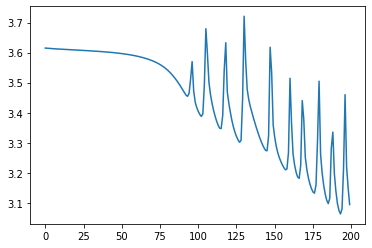

In [37]:
plt.plot(loss[0])
#plt.plot(eval_[1])
plt.show()

In [28]:
model = ConvNet()
model.load_state_dict(results["model_weights"])
model_scripted = torch.jit.script(model)
workpath = os.getenv('DEMO_WORK_PATH')
model_scripted.save(f'{workpath}/models/ray_model_scripted.pt')

2022-09-12 22:29:25,702	INFO common.py:219 -- Exception from actor creation is ignored in destructor. To receive this exception in application code, call a method on the actor reference before its destructor is run.


In [29]:
model = torch.jit.load(
    f"{workpath}/models/ray_model_scripted.pt",
    map_location=torch.device('cpu')).eval()

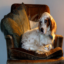

label:13
prediction: 26


In [30]:
train_features, train_labels = next(iter(data_loader))
make = ToPILImage()
make(train_features[0]).show()
print(f'label:{train_labels[0]}')
logits = model(train_features[0].reshape(1,3,64,64).to(device))
print(f"prediction: {torch.argmax(logits).item()}")

In [31]:
%%time
y_preds = []
gt = []
for X,y in data_loader:
    logits = model(X[0].reshape(1,3,64,64).to(device))
    y_pred = torch.argmax(logits).item()
    y_preds.append(y_pred)
    gt.append(y[0].item())

CPU times: user 28.6 s, sys: 189 ms, total: 28.8 s
Wall time: 14.5 s


In [32]:
%%time
for data in test_data.iter_batches():
    X = [x[0] for x in data]
    X = torch.stack(X)
    X = X.to("cpu")
    y = [torch.tensor(x[1]) for x in data]
    y = torch.stack(y)
    logits = model(X.to(device))
    y_preds = torch.argmax(logits, dim=1)
    y_preds = y_preds.to("cpu")

CPU times: user 1.59 s, sys: 663 ms, total: 2.26 s
Wall time: 2.27 s


In [33]:
from sklearn.metrics import accuracy_score, cohen_kappa_score
acc = accuracy_score(y_preds, y)
kap = cohen_kappa_score(y_preds, y)
print(f"Accuracy: {acc*100:.1f}%")
print(f"Random guess would yield {kap*100:.1f}%")
print(f"Model outperforms Random chance by a factor of {(acc/kap):.2f}")

Accuracy: 8.2%
Random guess would yield 5.7%
Model outperforms Random chance by a factor of 1.42


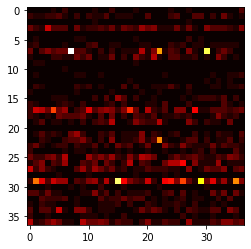

In [34]:
plt.imshow(confusion_matrix(y_preds,y), cmap='hot', interpolation='nearest')
plt.show()

In [35]:
print(classification_report(y_preds,y))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.02      0.02      0.02        46
           2       0.00      0.00      0.00         2
           3       0.17      0.08      0.11       102
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         7
           6       0.02      0.04      0.03        25
           7       0.65      0.20      0.31       138
           8       0.08      0.07      0.07        60
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00        29
          14       0.02      0.17      0.03         6
          15       0.12      0.18      0.14        34
          16       0.04      0.08      0.05        26
          17       0.24    

/opt/app-root/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/app-root/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/app-root/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
#stop_ray_cluster(cluster_name = ray_cluster_name)